
# Figure 1 (g500, 1008 dataset): 4×3 Grid of Sample Events

This notebook:
- Reads the **1008 g500** dataset CSVs (train/val).

In [1]:
import sys, os

# Get the absolute path of the parent folder (where config.py lives)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

print("Added to sys.path:", parent_dir)

Added to sys.path: /home/arsalan/wsu-grid/ml-jet-param-predictor


In [2]:
import os
import torch
import torch.nn as nn
import json

from config import get_config
from train_utils.gpu_utils import get_device_summary
from data.loader import get_dataloaders
from train_utils.resume import init_resume_state
from train_utils.resume import fill_trackers_from_history
from train_utils.resume import load_pretrained_model
from train_utils.training_loop import run_training_loop
from train_utils.scheduler_utils import create_scheduler
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy
from train_utils.plot_metrics import plot_confusion_matrices


In [3]:


from models.model_vit import create_model
cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
"experiments/exp_plotting_sample_g500_events/config/" \
"vit_tiny_patch16_224_gaussian_bs32_ep50_lr1e-04_p12_ds1008_g500_sched-RLRP_preload_p4.yml")

# from models.model_mamba import create_model
# cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
# "experiments/exp_alpha_s_evaluation_with_vit/config/" \
# "vit_tiny_patch16_224_gaussian_bs32_ep50_lr1e-04_p12_ds7200000_g500_sched-RLRP_preload_p4.yml")

# cfg=get_config()
print(json.dumps(vars(cfg), indent=2))

[INFO] Config Path: /home/arsalan/wsu-grid/ml-jet-param-predictor/experiments/exp_plotting_sample_g500_events/config/vit_tiny_patch16_224_gaussian_bs32_ep50_lr1e-04_p12_ds1008_g500_sched-RLRP_preload_p4.yml
[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled
[INFO] Using dataset_size from config: 1008
{
  "model_tag": "ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4",
  "backbone": "vit_gaussian",
  "batch_size": 32,
  "epochs": 50,
  "learning_rate": 0.0001,
  "patience": 12,
  "input_shape": [
    1,
    32,
    32
  ],
  "global_max": 121.79151153564453,
  "dataset_root_dir": "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled",
  "train_csv": "/home/arsalan/Projects/110_Jetsca

In [4]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")


[INFO] Saving all outputs to: experiments/exp_plotting_sample_g500_events/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded


In [5]:
device= get_device_summary()

=== NVIDIA-SMI ===
Wed Sep 10 17:54:47 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070        Off | 00000000:01:00.0  On |                  N/A |
| 30%   33C    P5              24W / 220W |    932MiB /  8192MiB |     28%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

In [6]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg, device=device)

[INFO] Training samples: 806
[INFO] Validation samples: 101
[INFO] Test samples: 101
[INFO] Length of training dataloader: 26
[INFO] Length of validation dataloader: 4
[INFO] Length of test dataloader: 4



- Picks **one sample** for each combination of **$Q_0 \in \{1.0, 1.5, 2.0, 2.5\}$** and **$\alpha_s \in \{0.2, 0.3, 0.4\}$**.
- Builds a **4×3** montage image (rows = $Q_0$; cols = $\alpha_s$) **without subplots** by composing tiles with PIL.
- Saves `figure1_g500_4x3.png` and shows it via a single `imshow` call (no seaborn, no custom colors).


In [ ]:
# %% Cell 6: Enhanced Single Plotter with Hist2D Style
def plot_single_jet(x, y):
    """
    Plot a single jet image with human-readable labels.

    Args:
        x (torch.Tensor): Input tensor of shape (1, 32, 32).
        y (dict): Dictionary containing labels.

    Returns:
        None
    """
    import math
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors

    # Maps for real parameter values
    energy_map = {0: 'MATTER', 1: 'MATTER-LBT'}
    alpha_vals = {0: 0.2, 1: 0.3, 2: 0.4}
    q0_vals    = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5}

    # Fetch first batch sample (ensure x, y from Cell 5 are in scope)
    img_tensor = x[0]                  # shape: (1,32,32)
    img = img_tensor.squeeze()         # shape: (32,32)
    if hasattr(img, 'cpu'):
        img = img.cpu().numpy()

    # Extract true labels
    energy_idx = y['energy_loss_output'][0].item()
    alpha_idx  = y['alpha_output'][0].item()
    q0_idx     = y['q0_output'][0].item()

    # Human-readable labels
    e_str = energy_map[energy_idx]
    α = alpha_vals[alpha_idx]
    Q0 = q0_vals[q0_idx]

    # Mask zero pixels
    img_masked = np.ma.masked_where(img == 0, img)

    # Define bin edges for [-π, π]
    x_edges = np.linspace(-math.pi, math.pi, img.shape[1] + 1)
    y_edges = np.linspace(-math.pi, math.pi, img.shape[0] + 1)

    # Plot
    plt.figure(figsize=(5, 5), dpi=200)
    pcm = plt.pcolormesh(
        x_edges, y_edges, img_masked,
        norm=colors.LogNorm(vmin=img_masked.min() or 1e-6, vmax=img_masked.max()),
        cmap='jet', shading='auto'
    )
    plt.colorbar(pcm, label='Normalized Intensity')
    plt.title(f'{e_str}, αₛ={α}, Q₀={Q0}', fontsize=12)

    # Shared axis ticks
    plt.xticks([-math.pi, 0, math.pi], [r'$-\pi$', '0', r'$\pi$'])
    plt.yticks([-math.pi, 0, math.pi], [r'$-\pi$', '0', r'$\pi$'])
    plt.xlabel('X (φ)')
    plt.ylabel('Y (η)')
    plt.show()
# plot_single_jet(x, y)

In [8]:
# %% Cell 7: Grid of Hist2D Plots with Real Labels (12×10)
def plot_grid_hist2d(agg_csv=None, root_dir=None, global_max=None):
    """
    Plot a grid of hist2D images for each (alpha, q0) combination.

    Args:
        agg_csv (str): Path to the aggregated CSV file.
        root_dir (str): Path to the root directory of the dataset.
        global_max (float): Global maximum value for normalization.

    Returns:
        None
    """
    import os
    import math
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    from itertools import product

    # Paths & constants
    dataset_root = os.path.expanduser(
        "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/"
    )
    agg_csv    = os.path.join(dataset_root, 'file_labels_aggregated_ds1008_g500_train.csv')
    global_max = 121.79151153564453

    # Reverse‐maps for real values
    energy_map = {0: 'MATTER', 1: 'MATTER-LBT'}
    alpha_vals = {0: 0.2, 1: 0.3, 2: 0.4}
    q0_vals    = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5}

    # Load aggregated entries
    df = pd.read_csv(agg_csv)

    # All (alpha_idx, q0_idx) combos → 3×4 = 12 rows
    combos = list(product([0,1,2], [0,1,2,3]))
    n_rows, n_cols = len(combos), 10

    # Create subplots
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols*1.5, n_rows*1.2),
        sharex='col', sharey='row',
        dpi=200
    )

    # Tight layout
    fig.subplots_adjust(
        left   = 0.15,  # room for row labels
        right  = 0.97,
        top    = 0.96,
        bottom = 0.02,
        hspace = 0.2,
        wspace = 0.1
    )

    # Bin edges
    x_edges = np.linspace(-math.pi, math.pi, 33)
    y_edges = np.linspace(-math.pi, math.pi, 33)

    for i, (a_idx, q_idx) in enumerate(combos):
        subset = df[(df['alpha']==a_idx) & (df['q0']==q_idx)]
        samples = subset.sample(n=n_cols, replace=len(subset)<n_cols, random_state=0)
        for j, (_, entry) in enumerate(samples.iterrows()):
            ax = axes[i, j]
            # Load & average
            imgs = [
                np.load(os.path.join(dataset_root, p)).astype(np.float32)/global_max
                for p in entry['file_paths'].split('|')
            ]
            avg = np.mean(imgs, axis=0)
            avg_masked = np.ma.masked_where(avg==0, avg)
            pcm = ax.pcolormesh(
                x_edges, y_edges, avg_masked,
                norm=colors.LogNorm(vmin=avg_masked.min() or 1e-6, vmax=avg_masked.max()),
                cmap='jet', shading='auto'
            )
            ax.set_xticks([]); ax.set_yticks([])
            # Real‐value row label
            if j == 0:
                e_str = energy_map[entry['energy_loss']]
                α = alpha_vals[a_idx]
                Q0 = q0_vals[q_idx]
                ax.text(-0.35, 0.5,
                        f'{e_str}\nαₛ={α}\nQ₀={Q0}',
                        transform=ax.transAxes,
                        va='center', ha='right',
                        fontsize=8)

    # Shared ticks bottom row & left column
    for ax in axes[-1, :]:
        ax.set_xticks([-math.pi, 0, math.pi])
        ax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'], fontsize=6)
    for ax in axes[:, 0]:
        ax.set_yticks([-math.pi, 0, math.pi])
        ax.set_yticklabels([r'$-\pi$', '0', r'$\pi$'], fontsize=6)

    # Colorbar
    cbar = fig.colorbar(pcm, ax=axes, fraction=0.015, pad=0.01)
    cbar.set_label('Normalized Intensity', fontsize=8)

    plt.suptitle('10 Aggregated Samples per (E, αₛ, Q₀) – Hist2D, X,Y ∈ [-π,π]', y=0.995, fontsize=12)
    plt.show()



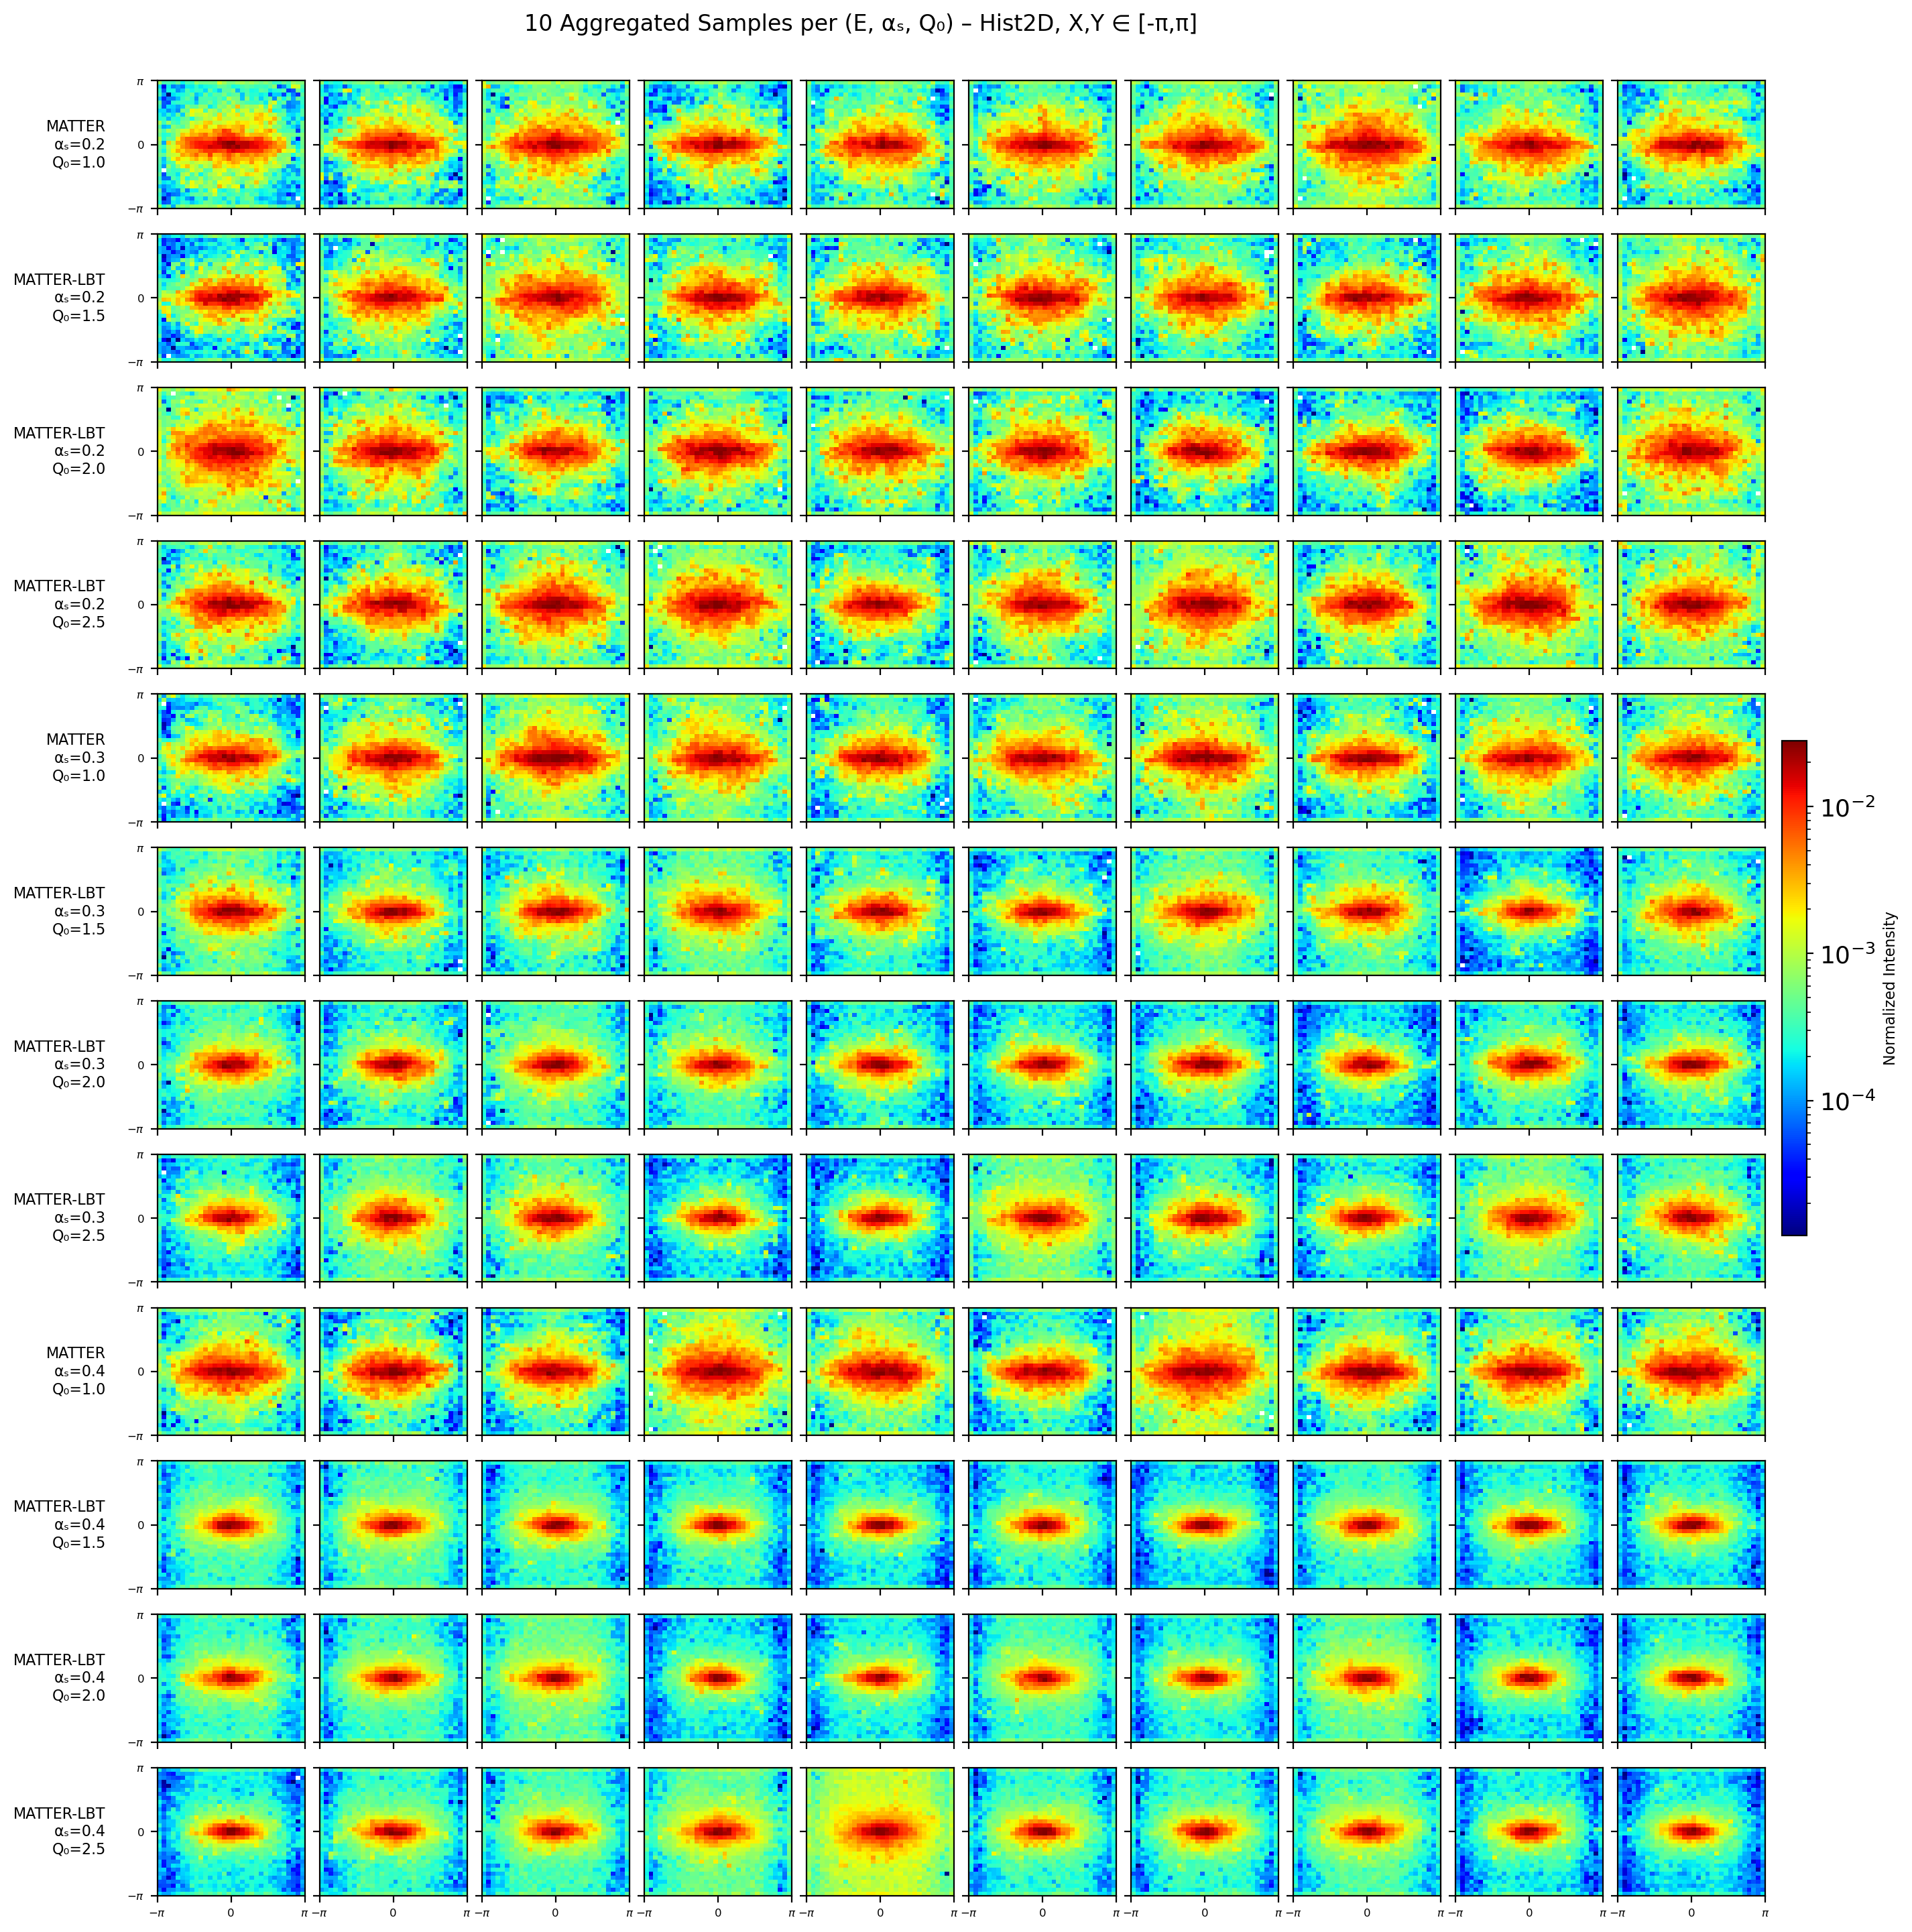

In [9]:
# plot_grid_hist2d(
#     agg_csv='/home/arsalan/wsu-grid/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/file_labels_aggregated_g1000.csv',
#     root_dir='/home/arsalan/wsu-grid/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/',
#     global_max=121.79151153564453
# )
plot_grid_hist2d()

In [7]:
def plot_avg_hist2d(entry, dataset_root, global_max=121.79151153564453):
    import numpy as np
    imgs = [
        np.load(os.path.join(dataset_root, p)).astype(np.float32)/global_max
        for p in entry['file_paths'].split('|')
    ]
    avg = np.mean(imgs, axis=0)
    avg_masked = np.ma.masked_where(avg==0, avg)
    return avg_masked

In [ ]:
# %% Cell 7: Grid of Hist2D Plots with Real Labels (12×10)
def plot_grid_hist2d_one_sample_per_combo(agg_csv='file_labels_aggregated_ds1008_g500_train.csv', 
                     dataset_root="/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/"):
    """
    Plot a grid of hist2D images for each (alpha, q0) combination.

    Args:
        agg_csv (str): Path to the aggregated CSV file.
        root_dir (str): Path to the root directory of the dataset.
        global_max (float): Global maximum value for normalization.

    Returns:
        None
    """
    import os
    import math
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    from itertools import product

    # Paths & constants
    dataset_root = os.path.expanduser(
        dataset_root
    )
    agg_csv    = os.path.join(dataset_root, agg_csv)

    # Reverse‐maps for real values
    energy_map = {0: 'MATTER', 1: 'MATTER-LBT'}
    alpha_vals = {0: 0.2, 1: 0.3, 2: 0.4}
    q0_vals    = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5}

    # Load aggregated entries
    df = pd.read_csv(agg_csv)

    # All (alpha_idx, q0_idx) combos → 3×4 = 12 rows
    combos = list(product([0,1,2], [0,1,2,3]))
    n_rows, n_cols = len(combos), 1

    # Create subplots
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols*1.5, n_rows*1.2),
        sharex='col', sharey='row',
        dpi=300
    )

    # Tight layout
    fig.subplots_adjust(
        left   = 0.15,  # room for row labels
        right  = 0.97,
        top    = 0.96,
        bottom = 0.02,
        hspace = 0.2,
        wspace = 0.1
    )

    # Bin edges
    x_edges = np.linspace(-math.pi, math.pi, 33)
    y_edges = np.linspace(-math.pi, math.pi, 33)

    for i, (a_idx, q_idx) in enumerate(combos):
        subset = df[(df['alpha']==a_idx) & (df['q0']==q_idx)]
        samples = subset.sample(n=n_cols, replace=len(subset)<n_cols, random_state=0)

        for j, (_, entry) in enumerate(samples.iterrows()):
            
            ax = axes[i, j]
            # Load & average
            avg_masked = plot_avg_hist2d(entry, dataset_root)
            pcm = ax.pcolormesh(
                x_edges, y_edges, avg_masked,
                norm=colors.LogNorm(vmin=avg_masked.min() or 1e-6, vmax=avg_masked.max()),
                cmap='jet', shading='auto'
            )
            ax.set_xticks([]); ax.set_yticks([])
            # Real‐value row label
            if j == 0:
                e_str = energy_map[entry['energy_loss']]
                α = alpha_vals[a_idx]
                Q0 = q0_vals[q_idx]
                ax.text(-0.35, 0.5,
                        f'{e_str}\nαₛ={α}\nQ₀={Q0}',
                        transform=ax.transAxes,
                        va='center', ha='right',
                        fontsize=8)

    # Shared ticks bottom row & left column
    for ax in axes[-1, :]:
        ax.set_xticks([-math.pi, 0, math.pi])
        ax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'], fontsize=6)
    for ax in axes[:, 0]:
        ax.set_yticks([-math.pi, 0, math.pi])
        ax.set_yticklabels([r'$-\pi$', '0', r'$\pi$'], fontsize=6)

    # Colorbar
    cbar = fig.colorbar(pcm, ax=axes, fraction=0.015, pad=0.01)
    cbar.set_label('Normalized Intensity', fontsize=8)

    plt.suptitle('10 Aggregated Samples per (E, αₛ, Q₀) – Hist2D, X,Y ∈ [-π,π]', y=0.995, fontsize=12)
    plt.show()



In [ ]:
plot_grid_hist2d_one_sample_per_combo()

In [23]:
def plot_grid_hist2d_one_sample_per_row(
    agg_csv='file_labels_aggregated_ds1008_g500_train.csv', 
    dataset_root="/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/"
):
    """
    Plot a vertical stack of hist2D images (one per row) for each (alpha, q0) combination.
    """

    import os, math
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    from itertools import product

    # Paths
    dataset_root = os.path.expanduser(dataset_root)
    agg_csv = os.path.join(dataset_root, agg_csv)

    # Reverse maps
    energy_map = {0: 'MATTER', 1: 'MATTER-LBT'}
    alpha_vals = {0: 0.2, 1: 0.3, 2: 0.4}
    q0_vals    = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5}

    # Load data
    df = pd.read_csv(agg_csv)

    # 12 combos (3 αs × 4 Q₀)
    combos = list(product([0,1,2], [0,1,2,3]))
    n_rows = len(combos)

    # Subplots: one column only
    fig, axes = plt.subplots(
        n_rows, 1,
        figsize=(2.5, n_rows * 1.5),
        dpi=300
    )

    if n_rows == 1:
        axes = [axes]  # ensure iterable

    # Bin edges
    x_edges = np.linspace(-math.pi, math.pi, 33)
    y_edges = np.linspace(-math.pi, math.pi, 33)

    for i, (a_idx, q_idx) in enumerate(combos):
        ax = axes[i]
        subset = df[(df['alpha']==a_idx) & (df['q0']==q_idx)]
        if subset.empty:
            ax.text(0.5, 0.5, "No Data", ha="center", va="center")
            ax.axis("off")
            continue

        entry = subset.sample(n=1, random_state=0).iloc[0]
        avg_masked = plot_avg_hist2d(entry, dataset_root)

        pcm = ax.pcolormesh(
            x_edges, y_edges, avg_masked,
            norm=colors.LogNorm(vmin=avg_masked.min() or 1e-6, vmax=avg_masked.max()),
            cmap='jet', shading='auto'
        )
        ax.set_xticks([]); ax.set_yticks([])

        # Row label
        e_str = energy_map[entry['energy_loss']]
        α = alpha_vals[a_idx]
        Q0 = q0_vals[q_idx]
        ax.set_ylabel(f'{e_str}\nαₛ={α}\nQ₀={Q0}', fontsize=8, rotation=0, labelpad=30, va='center')

    # Colorbar on the side
    cbar = fig.colorbar(pcm, ax=axes, fraction=0.02, pad=0.02)
    cbar.set_label('Normalized Intensity', fontsize=8)

    plt.suptitle('One Sample per (E, αₛ, Q₀) – Hist2D', y=0.995, fontsize=12)
    plt.tight_layout(rect=[0,0,1,0.97])
    plt.show()


/tmp/ipykernel_190793/2002559457.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.97])


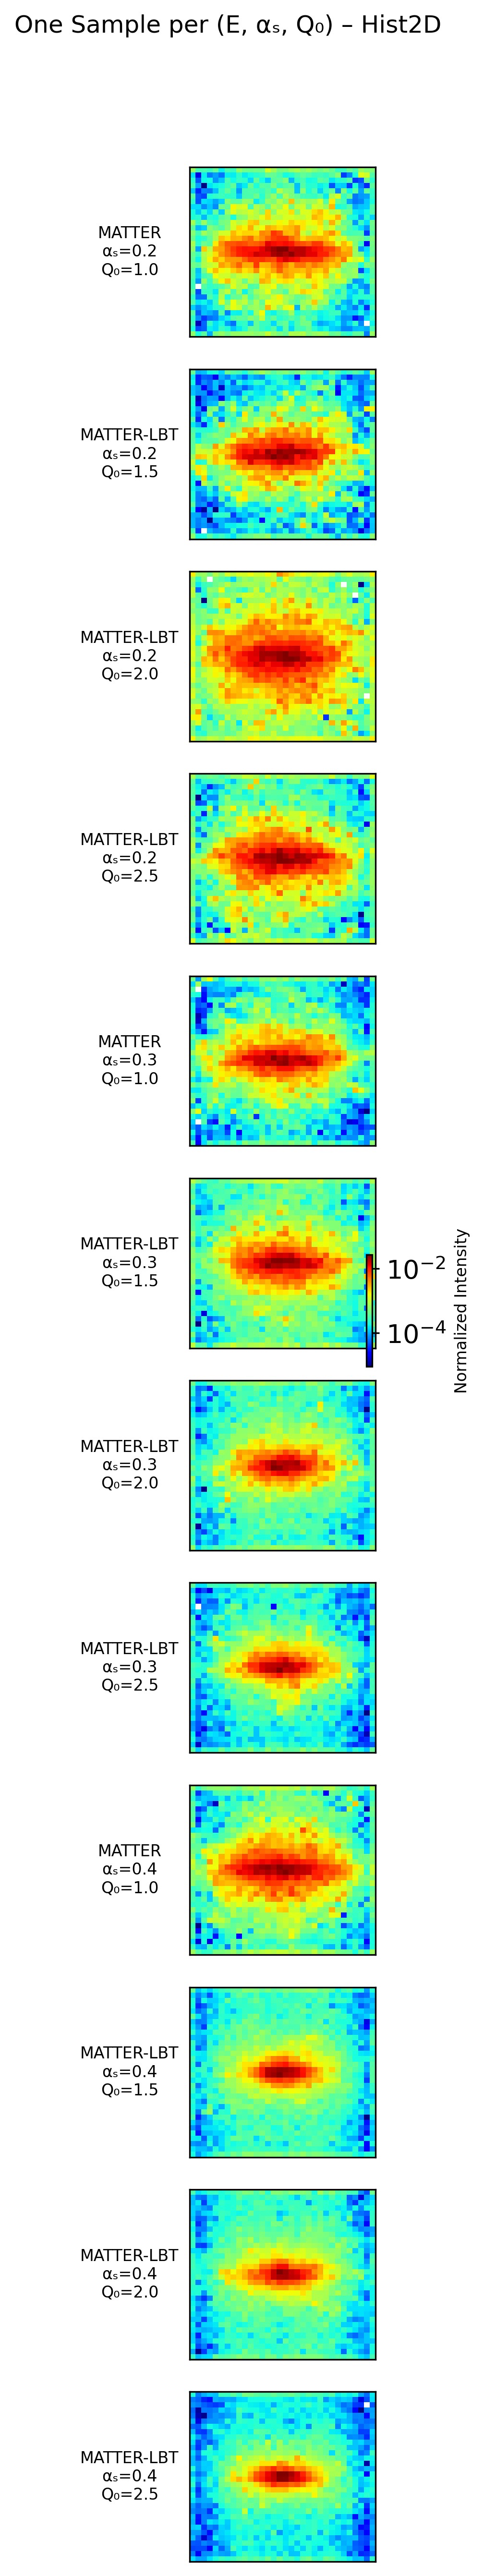

In [24]:
plot_grid_hist2d_one_sample_per_row()


/tmp/ipykernel_6595/1491345996.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


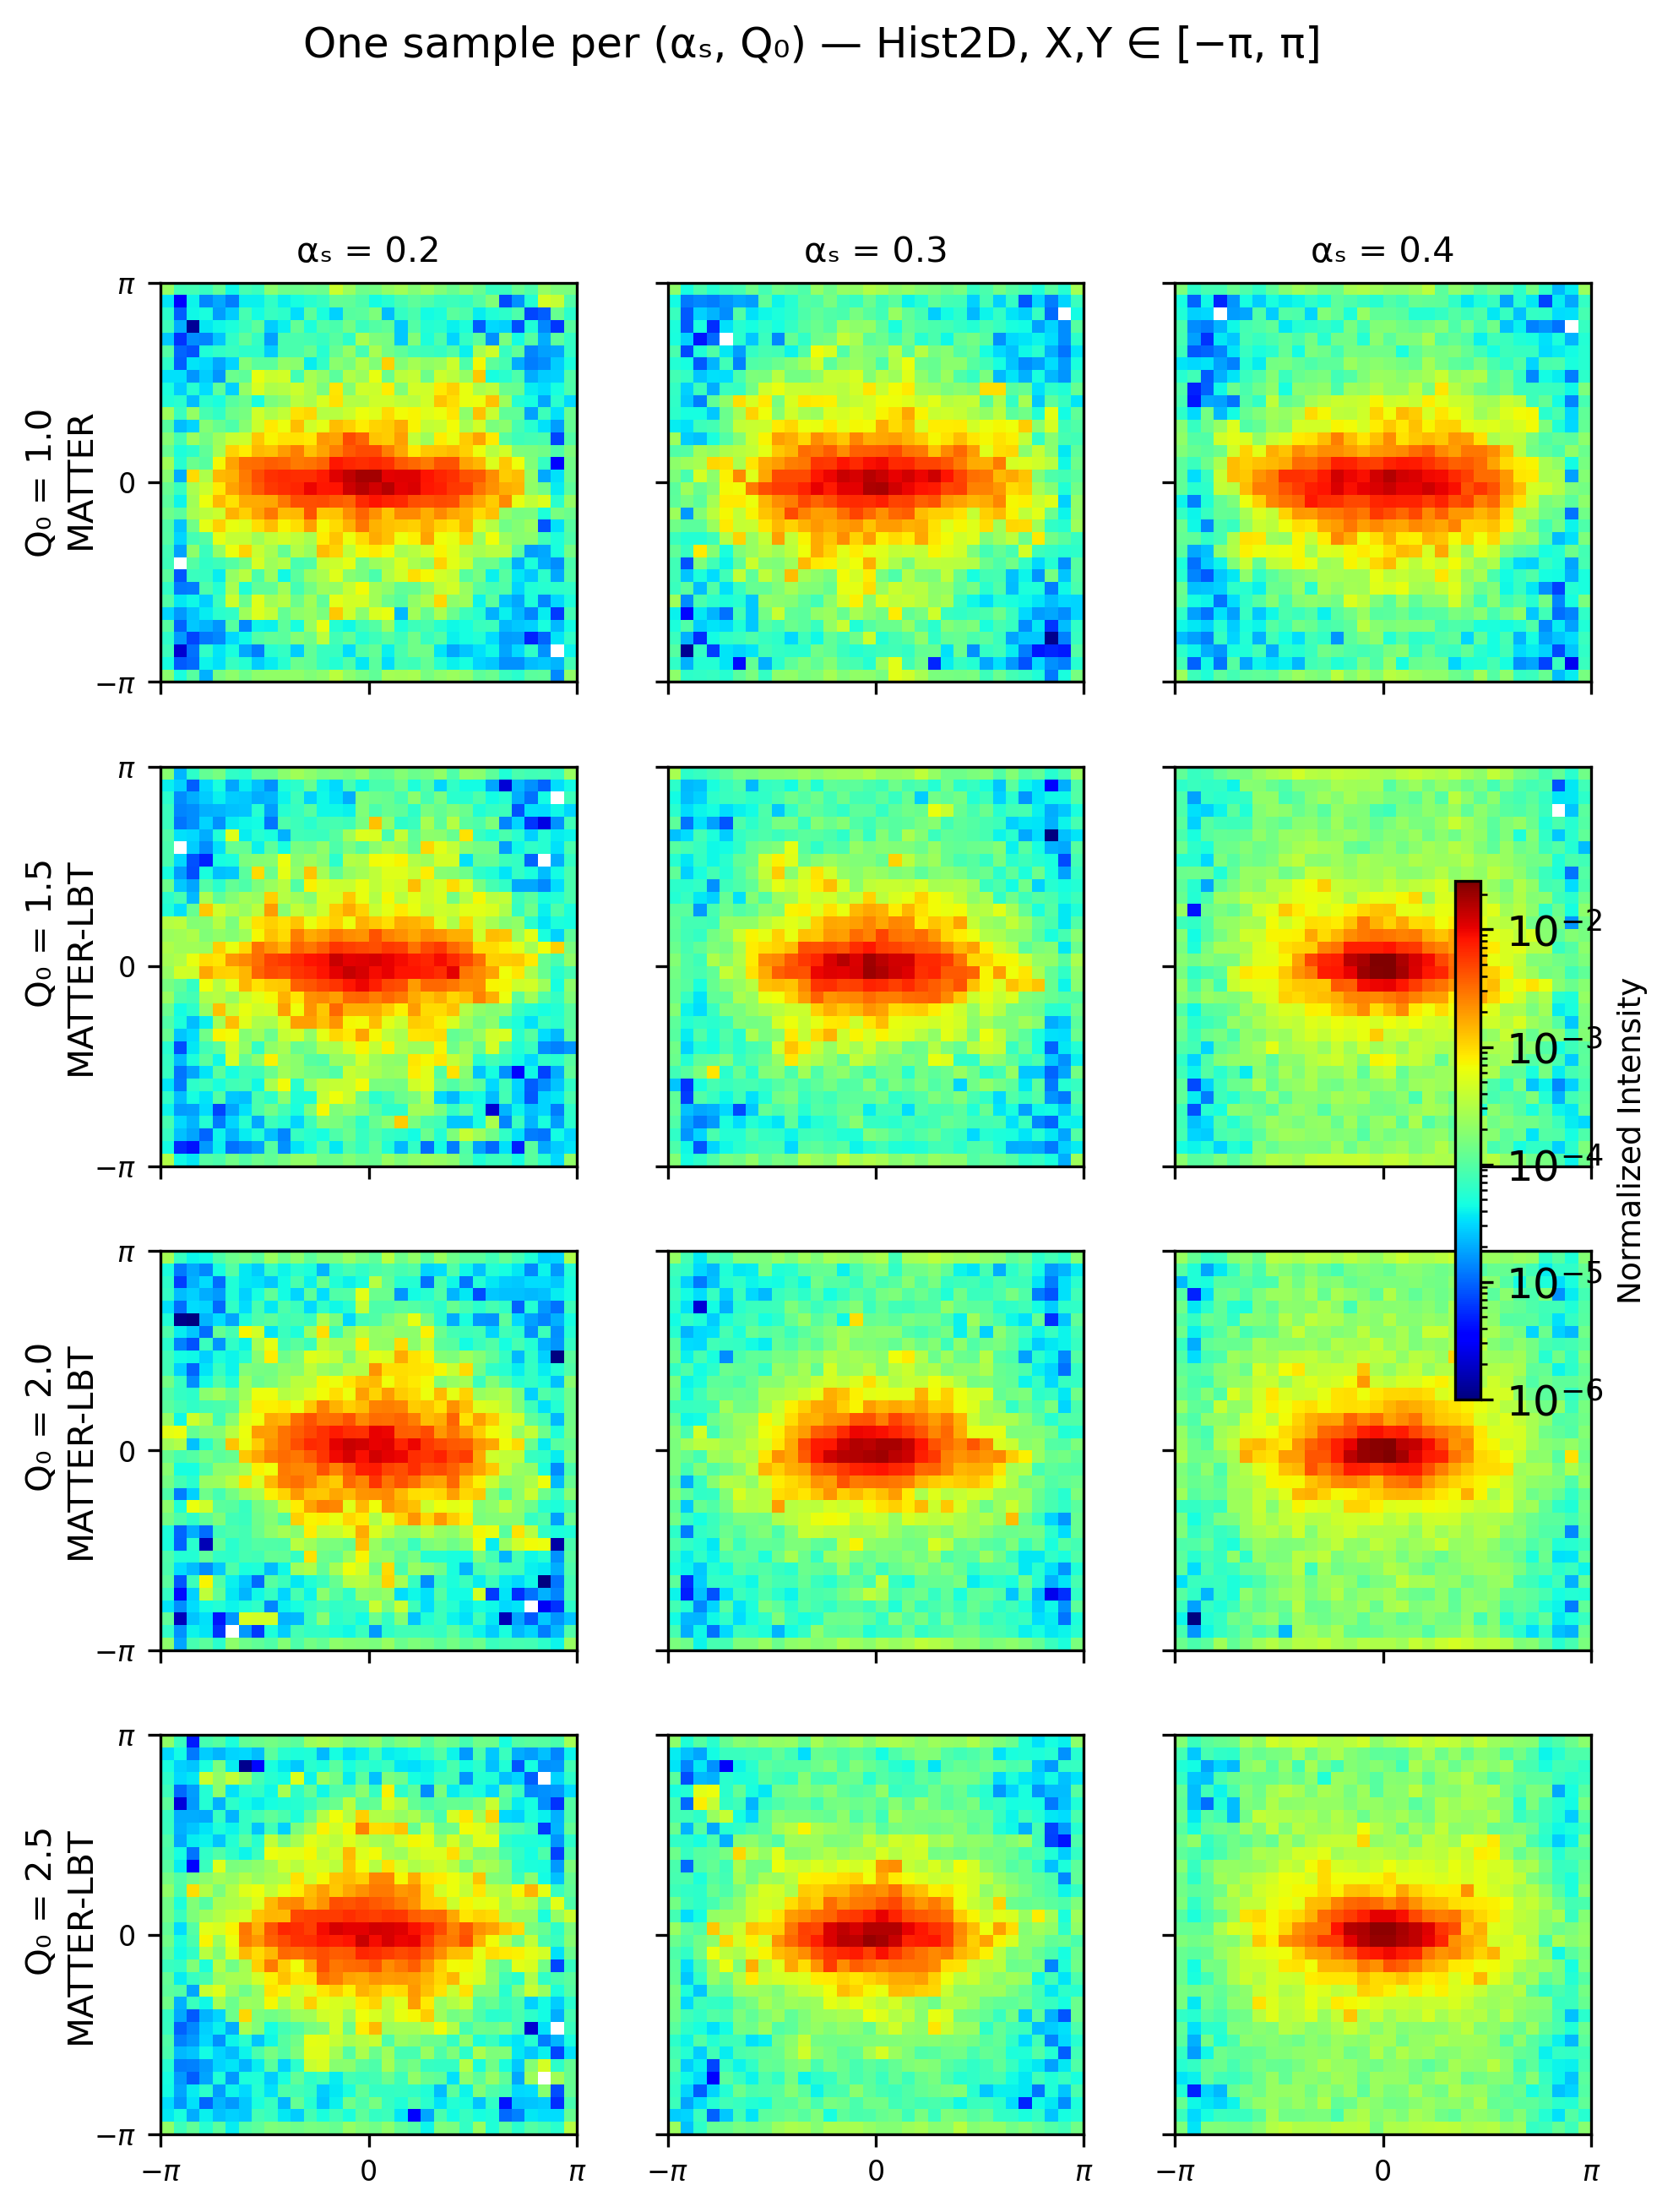

In [81]:
def plot_grid_hist2d_one_sample_per_combo_4x3(
    agg_csv='file_labels_aggregated_ds1008_g500_train.csv',
    dataset_root="/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/",
    module_value=None,  # None, "MATTER", or "MATTER-LBT"
    random_state=0
):
    """
    Plot a 4x3 grid (rows=Q0, cols=alpha_s), one Hist2D sample per (alpha,q0) combo.
    If module_value is provided, restrict picks to that energy-loss module.
    """
    import os, math
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors

    # ---- paths & constants
    dataset_root = os.path.expanduser(dataset_root)
    agg_csv_path = os.path.join(dataset_root, agg_csv)

    # label maps
    energy_map = {0: 'MATTER', 1: 'MATTER-LBT'}
    energy_inv = {v: k for k, v in energy_map.items()}
    alpha_vals = {0: 0.2, 1: 0.3, 2: 0.4}
    q0_vals    = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5}

    alphas = [0, 1, 2]   # indices for columns
    q0s    = [0, 1, 2, 3]  # indices for rows

    # ---- load
    df = pd.read_csv(agg_csv_path)

    # optional module filter
    if module_value is not None:
        if module_value not in energy_inv:
            raise ValueError("module_value must be 'MATTER' or 'MATTER-LBT' or None")
        df = df[df['energy_loss'] == energy_inv[module_value]]

    # ---- figure
    n_rows, n_cols = len(q0s), len(alphas)
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 2.2, n_rows * 2.2),
        dpi=300,
        sharex=True, sharey=True
    )

    # bins (32×32 edges)
    x_edges = np.linspace(-math.pi, math.pi, 33)
    y_edges = np.linspace(-math.pi, math.pi, 33)

    # first pass: collect one sample image per cell to get shared vmin/vmax
    cell_images = [[None for _ in alphas] for _ in q0s]
    vmin_list, vmax_list = [], []
    rng = np.random.RandomState(random_state)

    for r, q_idx in enumerate(q0s):
        for c, a_idx in enumerate(alphas):
            subset = df[(df['alpha'] == a_idx) & (df['q0'] == q_idx)]
            if subset.empty:
                continue
            entry = subset.sample(n=1, random_state=rng).iloc[0]
            img = plot_avg_hist2d(entry, dataset_root)  # assumes available in your notebook
            cell_images[r][c] = (img, entry)
            # guard zero for LogNorm
            mn = np.nanmin(img[img > 0]) if (img > 0).any() else 1e-6
            mx = np.nanmax(img)
            vmin_list.append(max(mn, 1e-6))
            vmax_list.append(mx)

    # shared color scale (log)
    if vmin_list and vmax_list:
        vmin = min(vmin_list)
        vmax = max(vmax_list)
    else:
        vmin, vmax = 1e-6, 1.0  # fallback

    # second pass: plot
    last_pcm = None
    for r, q_idx in enumerate(q0s):
        for c, a_idx in enumerate(alphas):
            ax = axes[r, c]
            ax.set_xticks([]); ax.set_yticks([])

            payload = cell_images[r][c]
            if payload is None:
                ax.text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=9)
                continue

            img, entry = payload
            pcm = ax.pcolormesh(
                x_edges, y_edges, img,
                norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                cmap='jet', shading='auto'
            )
            last_pcm = pcm

            # top col titles: alpha
            if r == 0:
                ax.set_title(f"αₛ = {alpha_vals[a_idx]}", fontsize=10, pad=6)

            # left row labels: Q0 (+ module if fixed)
            if c == 0:
                row_label = f"Q₀ = {q0_vals[q_idx]}"
                if module_value is None:
                    # show the sampled entry's module so row label is still clear
                    row_label = f"{row_label}\n{energy_map[entry['energy_loss']]}"
                else:
                    row_label = f"{row_label}\n{module_value}"
                ax.text(-0.15, 0.5, row_label, va='center', ha='right',
                        rotation=90, transform=ax.transAxes, fontsize=10)

    # ticks only on outer edges for readability
    for ax in axes[-1, :]:
        ax.set_xticks([-math.pi, 0, math.pi])
        ax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'], fontsize=8)
    for ax in axes[:, 0]:
        ax.set_yticks([-math.pi, 0, math.pi])
        ax.set_yticklabels([r'$-\pi$', '0', r'$\pi$'], fontsize=8)

    # colorbar
    if last_pcm is not None:
        cbar = fig.colorbar(last_pcm, ax=axes, fraction=0.02, pad=0.02)
        cbar.set_label('Normalized Intensity', fontsize=9)

    title_mod = f" — {module_value}" if module_value else ""
    plt.suptitle(f'One sample per (αₛ, Q₀){title_mod} — Hist2D, X,Y ∈ [−π, π]', y=0.995, fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
plot_grid_hist2d_one_sample_per_combo_4x3()

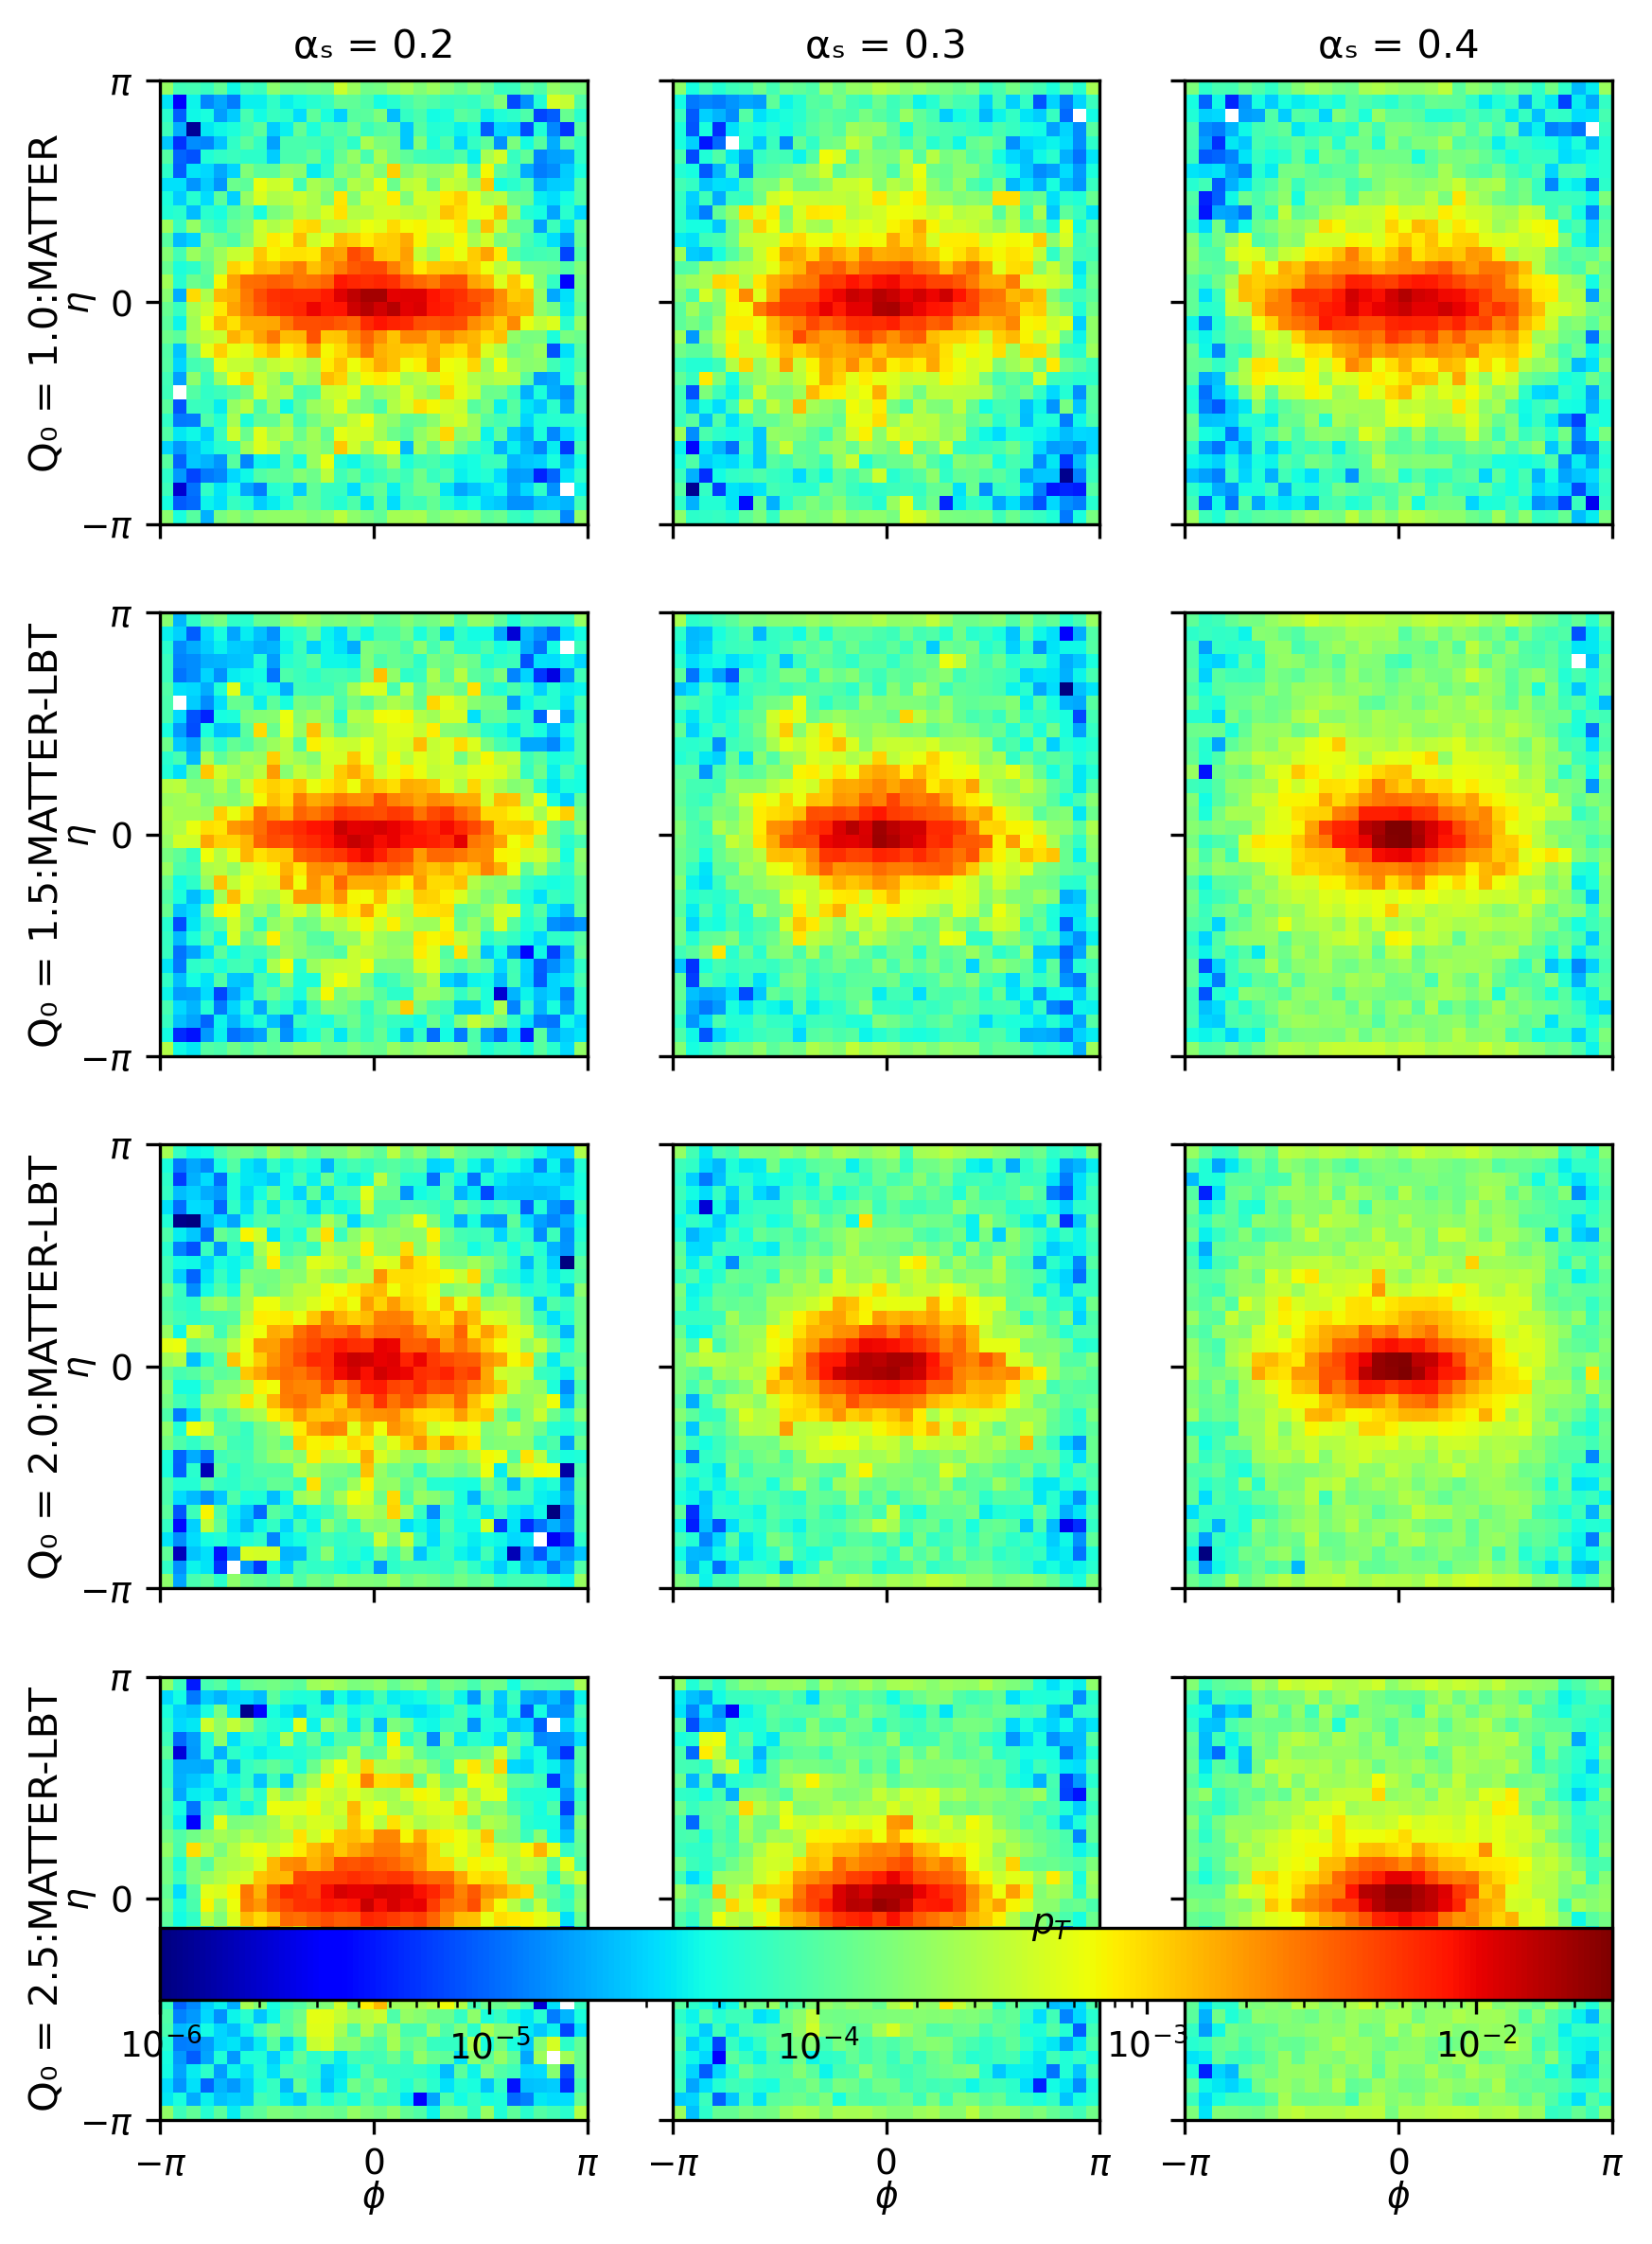

In [95]:
def plot_grid_hist2d_one_sample_per_combo_4x3(
    agg_csv='file_labels_aggregated_ds1008_g500_train.csv',
    dataset_root="/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/",
    module_value=None,  # None, "MATTER", or "MATTER-LBT"
    random_state=0
):
    """
    Plot a 4x3 grid (rows=Q0, cols=alpha_s), one Hist2D sample per (alpha,q0) combo.
    Adds a single horizontal colorbar at the bottom labeled 'Pseudorapidity'.
    """
    import os, math
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors

    # ---- paths & constants
    dataset_root = os.path.expanduser(dataset_root)
    agg_csv_path = os.path.join(dataset_root, agg_csv)

    # label maps
    energy_map = {0: 'MATTER', 1: 'MATTER-LBT'}
    energy_inv = {v: k for k, v in energy_map.items()}
    alpha_vals = {0: 0.2, 1: 0.3, 2: 0.4}
    q0_vals    = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5}

    alphas = [0, 1, 2]   # indices for columns
    q0s    = [0, 1, 2, 3]  # indices for rows

    # ---- load
    df = pd.read_csv(agg_csv_path)
    if module_value is not None:
        df = df[df['energy_loss'] == energy_inv[module_value]]

    # ---- figure
    n_rows, n_cols = len(q0s), len(alphas)
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 2.2, n_rows * 2.2),
        dpi=300,
        sharex=True, sharey=True
    )

    # bins
    x_edges = np.linspace(-math.pi, math.pi, 33)
    y_edges = np.linspace(-math.pi, math.pi, 33)

    # collect one sample per cell
    cell_images = [[None for _ in alphas] for _ in q0s]
    vmin_list, vmax_list = [], []
    rng = np.random.RandomState(random_state)

    for r, q_idx in enumerate(q0s):
        for c, a_idx in enumerate(alphas):
            subset = df[(df['alpha'] == a_idx) & (df['q0'] == q_idx)]
            if subset.empty:
                continue
            entry = subset.sample(n=1, random_state=rng).iloc[0]
            img = plot_avg_hist2d(entry, dataset_root)
            cell_images[r][c] = (img, entry)
            mn = np.nanmin(img[img > 0]) if (img > 0).any() else 1e-6
            mx = np.nanmax(img)
            vmin_list.append(max(mn, 1e-6))
            vmax_list.append(mx)

    # shared scale
    vmin = min(vmin_list) if vmin_list else 1e-6
    vmax = max(vmax_list) if vmax_list else 1.0

    last_pcm = None
    for r, q_idx in enumerate(q0s):
        for c, a_idx in enumerate(alphas):
            ax = axes[r, c]
            ax.set_xticks([]); ax.set_yticks([])
            payload = cell_images[r][c]
            if payload is None:
                ax.text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=9)
                continue
            img, entry = payload
            pcm = ax.pcolormesh(
                x_edges, y_edges, img,
                norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                cmap='jet', shading='auto'
            )
            last_pcm = pcm
            if r == 0:
                ax.set_title(f"αₛ = {alpha_vals[a_idx]}", fontsize=10, pad=6)
            if c == 0:
                row_label = f"Q₀ = {q0_vals[q_idx]}"
                if module_value is None:
                    row_label = f"{row_label}:{energy_map[entry['energy_loss']]}"
                else:
                    row_label = f"{row_label}\n{module_value}"
                ax.text(-0.22, 0.5, row_label, va='center', ha='right',
                        rotation=90, transform=ax.transAxes, fontsize=10)

    # outer ticks
    for ax in axes[-1, :]:
        ax.set_xticks([-math.pi, 0, math.pi])
        ax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'], fontsize=9)
        ax.set_xlabel(r'$\phi$', fontsize=9, labelpad=-1)
    for ax in axes[:, 0]:
        ax.set_yticks([-math.pi, 0, math.pi])
        ax.set_yticklabels([r'$-\pi$', '0', r'$\pi$'], fontsize=9)
        ax.set_ylabel(r'$\eta$', fontsize=9, rotation=90, labelpad=-5)

    # horizontal colorbar at bottom
    if last_pcm is not None:
        cbar = fig.colorbar(
            last_pcm, ax=axes,
            fraction=0.04, pad=-0.1,
            orientation='horizontal', location='bottom'
        )
        # cbar.set_label(r'p_T', fontsize=9)
        cbar.ax.set_title(r"$p_T$", fontsize=9, pad=6, loc='left',x=0.6, y=0.6)
        cbar.ax.tick_params(labelsize=9)   # change 10 to whatever size you want

    # plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    # plt.tight_layout()
    plt.show()
plot_grid_hist2d_one_sample_per_combo_4x3()


In [10]:
def plot_grid_hist2d_one_sample_per_combo_4x3(
    agg_csv='file_labels_aggregated_ds1008_g500_train.csv',
    dataset_root="/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/",
    module_value=None,  # None, "MATTER", or "MATTER-LBT"
    random_state=0
):
    """
    Plot a 4x3 grid (rows=Q0, cols=alpha_s), one Hist2D sample per (alpha,q0) combo.
    If module_value is provided, restrict picks to that energy-loss module.
    """
    import os, math
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    # Increase font sizes globally
    plt.rcParams.update({
        'axes.titlesize': 18,       # Title font size
        'axes.labelsize': 14,       # Axis label font size
        'xtick.labelsize': 12,      # X-tick font size
        'ytick.labelsize': 12,      # Y-tick font size,
    })

    # ---- paths & constants
    dataset_root = os.path.expanduser(dataset_root)
    agg_csv_path = os.path.join(dataset_root, agg_csv)

    # label maps
    energy_map = {0: 'MATTER', 1: 'MATTER-LBT'}
    energy_inv = {v: k for k, v in energy_map.items()}
    alpha_vals = {0: 0.2, 1: 0.3, 2: 0.4}
    q0_vals    = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5}

    alphas = [0, 1, 2]   # indices for columns
    q0s    = [0, 1, 2, 3]  # indices for rows

    # ---- load
    df = pd.read_csv(agg_csv_path)

    # optional module filter
    if module_value is not None:
        if module_value not in energy_inv:
            raise ValueError("module_value must be 'MATTER' or 'MATTER-LBT' or None")
        df = df[df['energy_loss'] == energy_inv[module_value]]

    # ---- figure
    n_rows, n_cols = len(q0s), len(alphas)
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 2.2, n_rows * 2.2),
        dpi=300,
        sharex=True, sharey=True
    )

    # bins (32×32 edges)
    x_edges = np.linspace(-math.pi, math.pi, 33)
    y_edges = np.linspace(-math.pi, math.pi, 33)

    # first pass: collect one sample image per cell to get shared vmin/vmax
    cell_images = [[None for _ in alphas] for _ in q0s]
    vmin_list, vmax_list = [], []
    rng = np.random.RandomState(random_state)

    for r, q_idx in enumerate(q0s):
        for c, a_idx in enumerate(alphas):
            subset = df[(df['alpha'] == a_idx) & (df['q0'] == q_idx)]
            if subset.empty:
                continue
            entry = subset.sample(n=1, random_state=rng).iloc[0]
            img = plot_avg_hist2d(entry, dataset_root)  # assumes available in your notebook
            cell_images[r][c] = (img, entry)
            # guard zero for LogNorm
            mn = np.nanmin(img[img > 0]) if (img > 0).any() else 1e-6
            mx = np.nanmax(img)
            vmin_list.append(max(mn, 1e-6))
            vmax_list.append(mx)

    # shared color scale (log)
    if vmin_list and vmax_list:
        vmin = min(vmin_list)
        vmax = max(vmax_list)
    else:
        vmin, vmax = 1e-6, 1.0  # fallback

    # second pass: plot
    last_pcm = None
    for r, q_idx in enumerate(q0s):
        for c, a_idx in enumerate(alphas):
            ax = axes[r, c]
            ax.set_xticks([]); ax.set_yticks([])

            payload = cell_images[r][c]
            if payload is None:
                ax.text(0.5, 0.5, "N/A", ha="center", va="center")
                continue

            img, entry = payload
            pcm = ax.pcolormesh(
                x_edges, y_edges, img,
                norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                cmap='jet', shading='auto'
            )
            last_pcm = pcm

            # top col titles: alpha
            if r == 0:
                ax.set_title(f"αₛ = {alpha_vals[a_idx]}", pad=6)

            # left row labels: Q0 (+ module if fixed)
            if c == 0:
                row_label = f"Q₀ = {q0_vals[q_idx]}"
                if module_value is None:
                    # show the sampled entry's module so row label is still clear
                    row_label = f"{row_label}\n{energy_map[entry['energy_loss']]}"
                else:
                    row_label = f"{row_label}\n{module_value}"
                ax.text(-0.15, 0.5, row_label, va='center', ha='right',
                        rotation=90, transform=ax.transAxes)

    # ticks only on outer edges for readability
    for ax in axes[-1, :]:
        ax.set_xticks([-math.pi, 0, math.pi])
        ax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
    for ax in axes[:, 0]:
        ax.set_yticks([-math.pi, 0, math.pi])
        ax.set_yticklabels([r'$-\pi$', '0', r'$\pi$'])
    # colorbar
    if last_pcm is not None:
        cbar = fig.colorbar(last_pcm,
                            ax=axes,
                            fraction=0.02,
                            pad=0.02,
                            )
        # cbar.set_label('Normalized Intensity', fontsize=9)

    
    # plt.tight_layout(rect=[0, 0, 1, 0.97])
    # fig.tight_layout()
    plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])  # Ensure room for the legends outside
    plt.show()


/tmp/ipykernel_202541/174111253.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])  # Ensure room for the legends outside


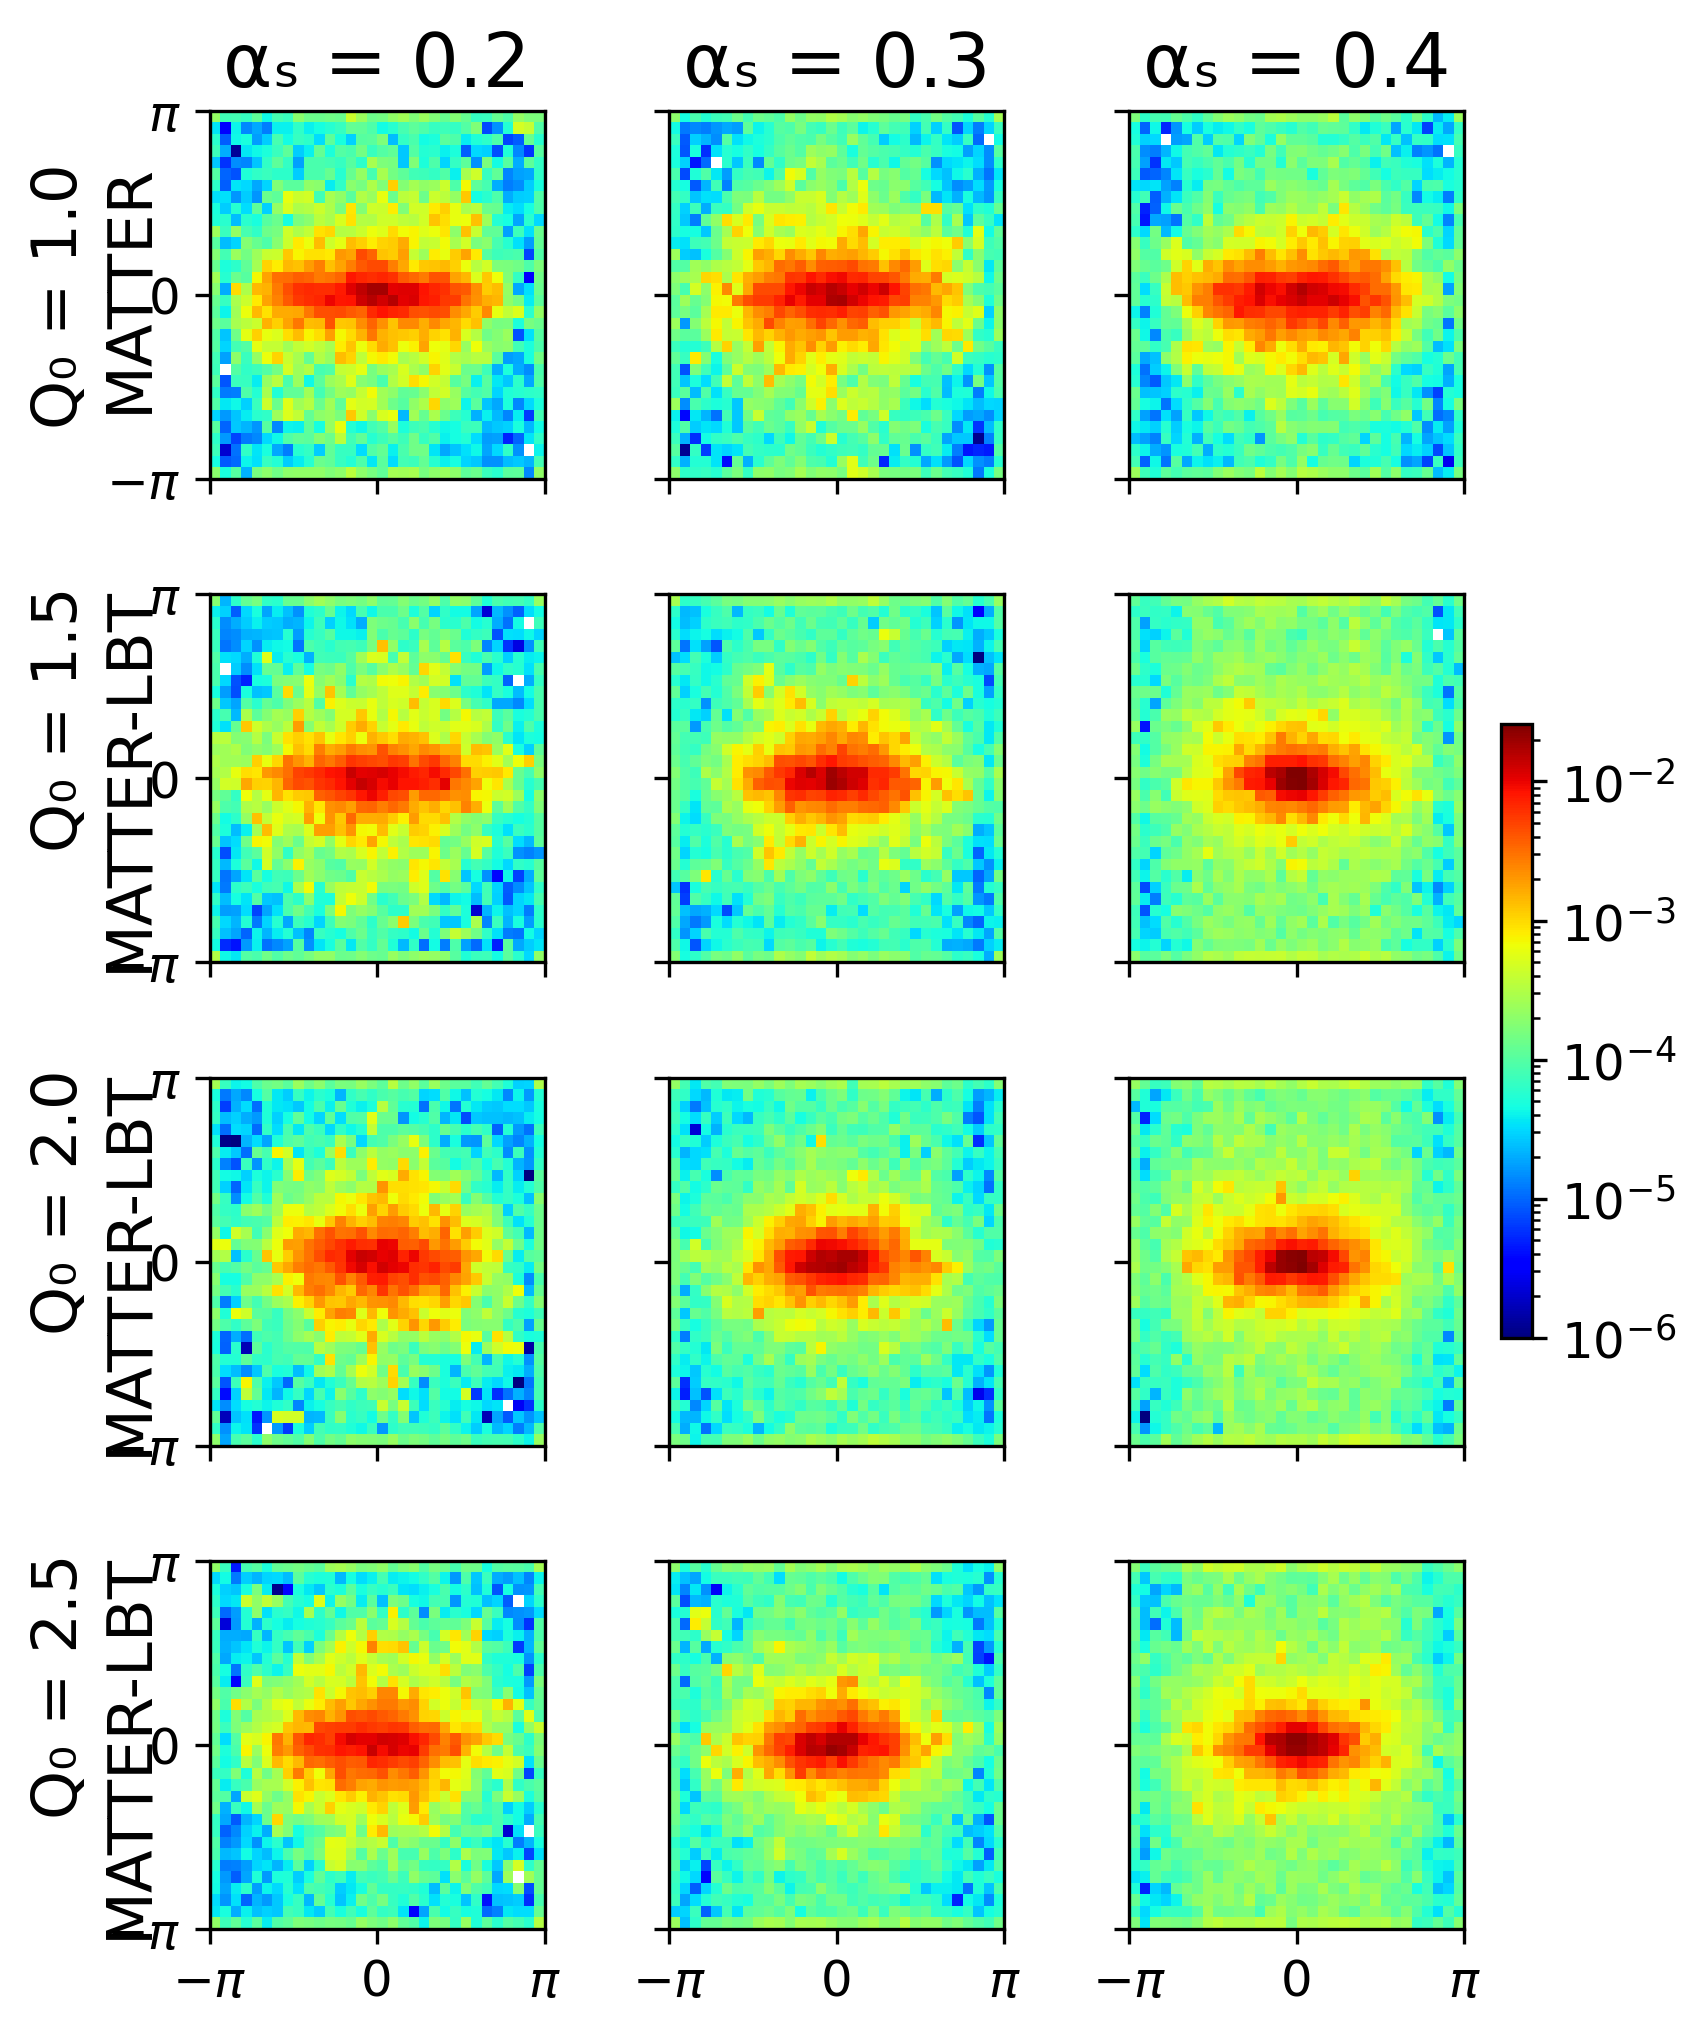

In [11]:
plot_grid_hist2d_one_sample_per_combo_4x3()

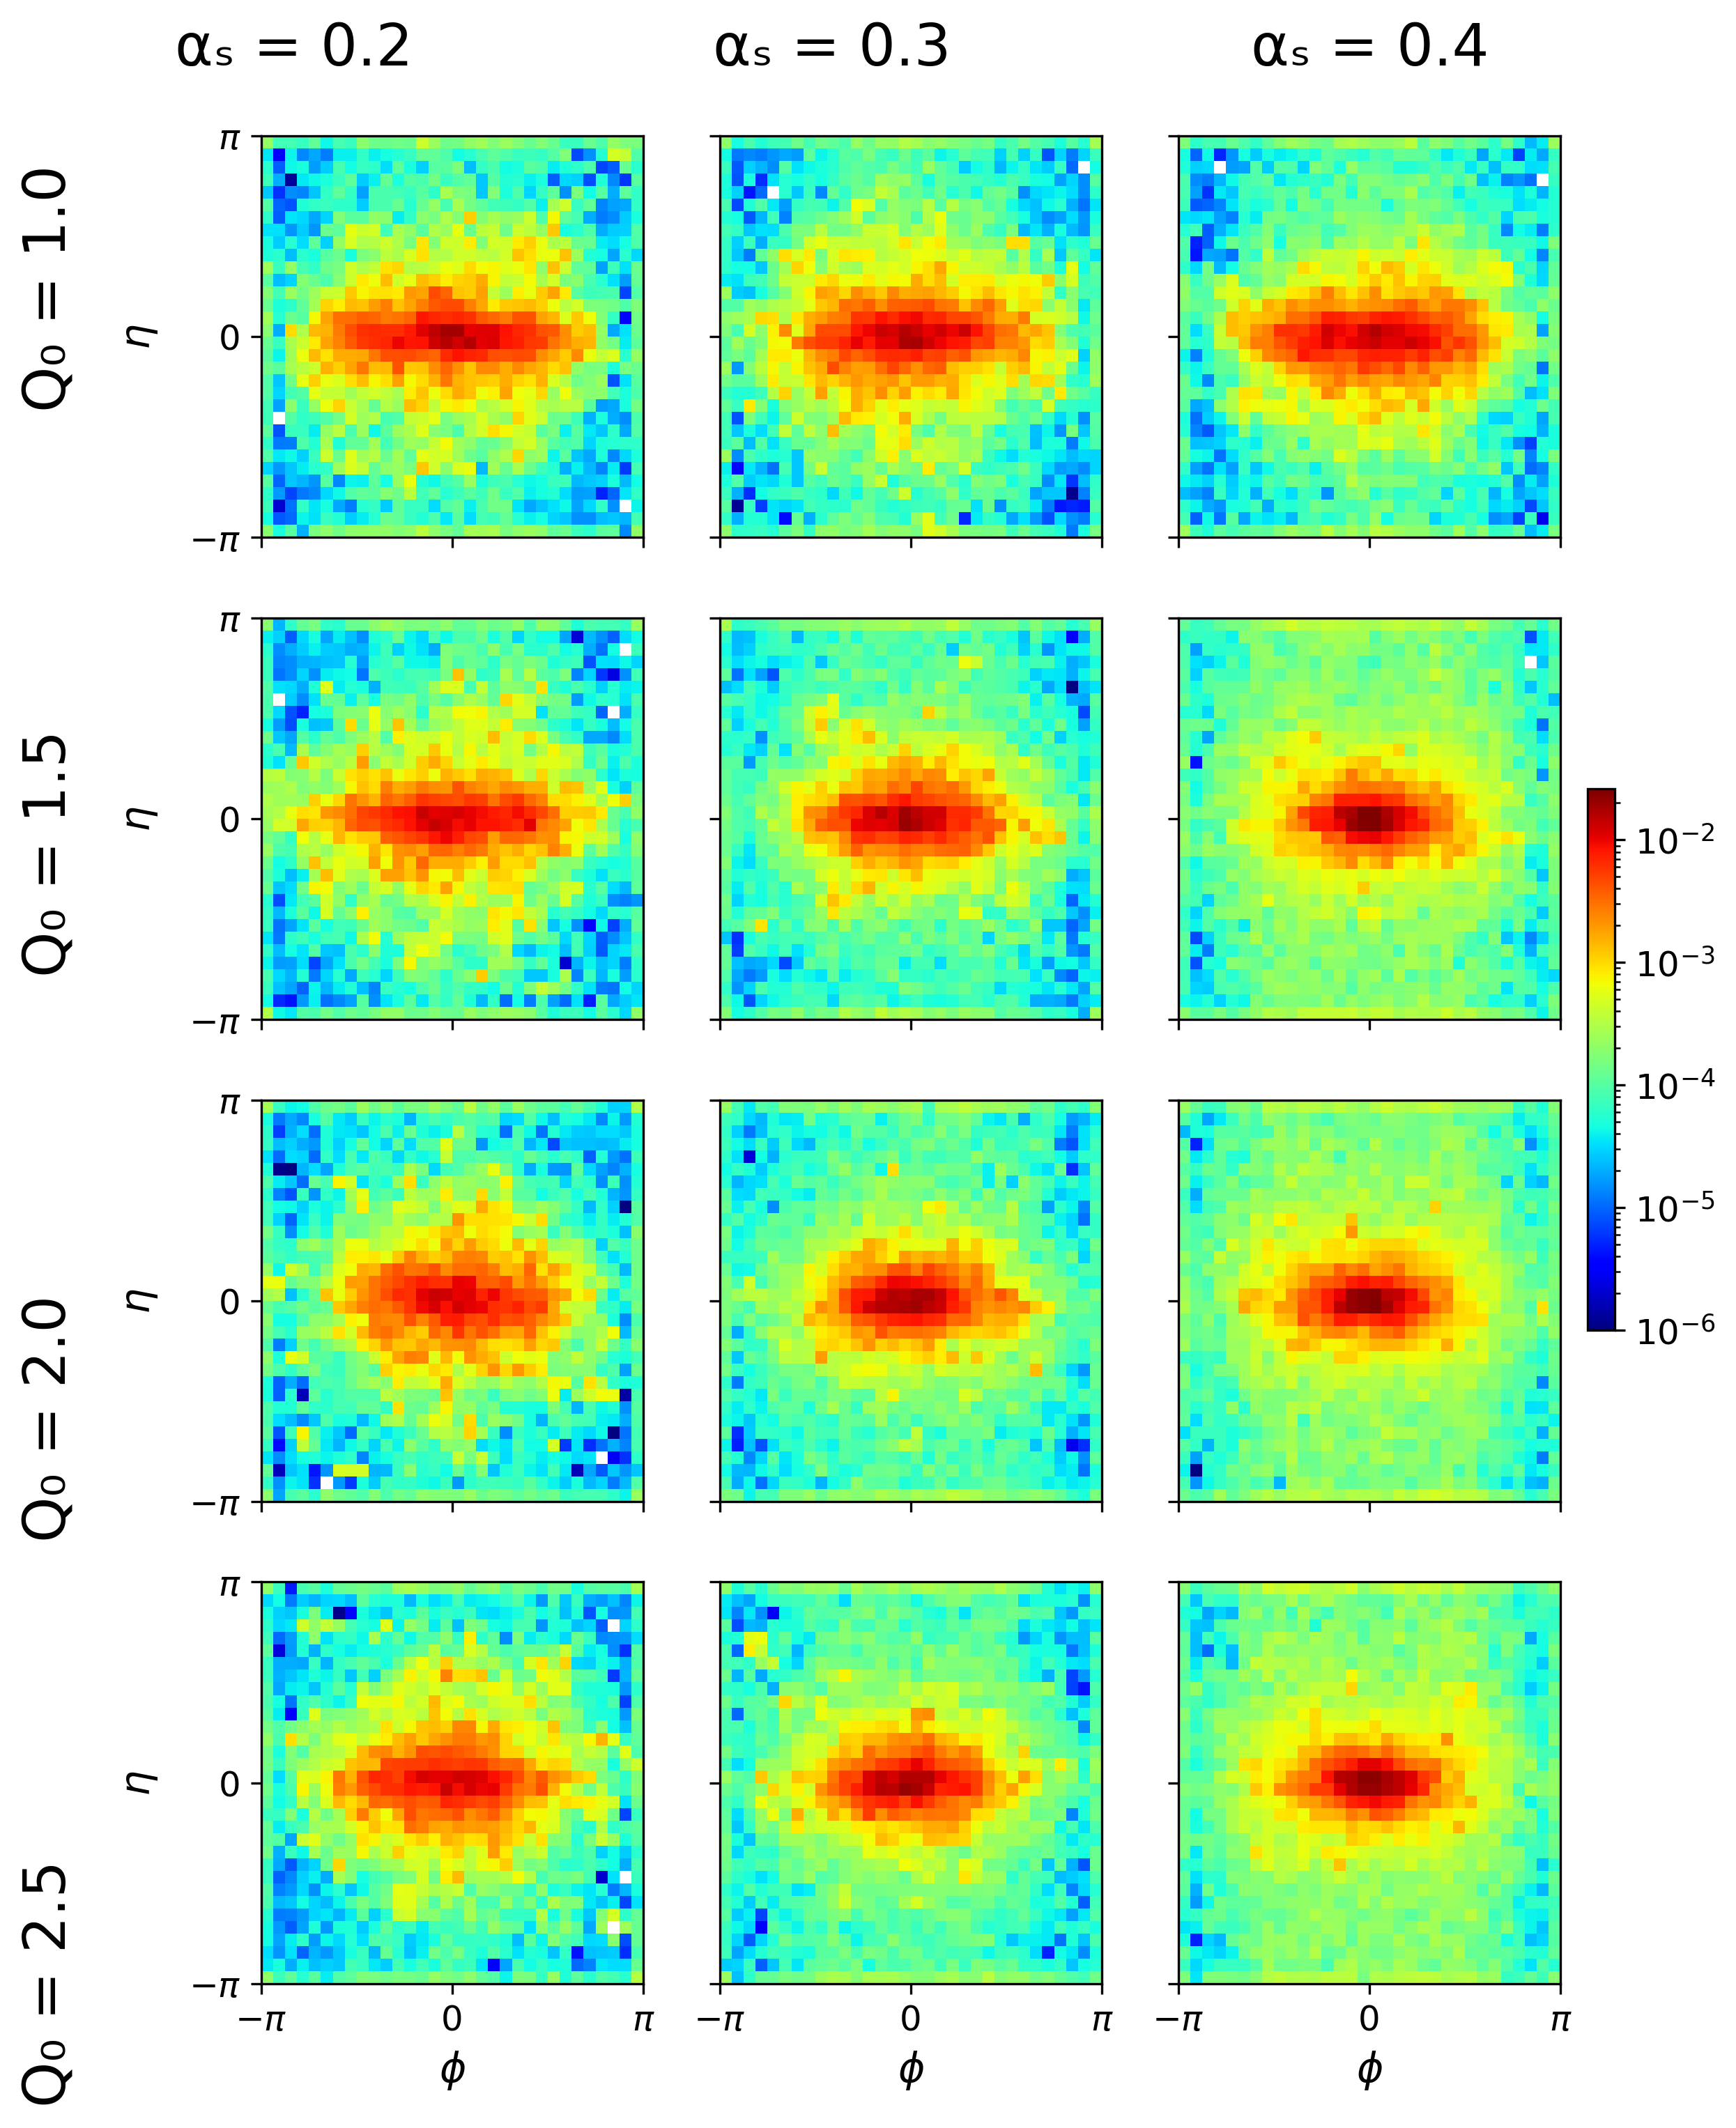

In [ ]:
def plot_grid_hist2d_one_sample_per_combo_4x3(
    agg_csv='file_labels_aggregated_ds1008_g500_train.csv',
    dataset_root="/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/",
    module_value=None,         # None, "MATTER", or "MATTER-LBT"
    random_state=0,
    save_path=None,            # e.g., "/path/to/figure.pdf" (optional)
    col_titles=(r"αₛ = 0.2", r"αₛ = 0.3", r"αₛ = 0.4"),   # figure-level column titles
    row_titles=None            # figure-level row titles; if None, auto from Q₀ (+ module)
):
    """
    Plot a 4×3 grid (rows=Q₀, cols=αₛ), one Hist2D sample per (α, Q₀) combo,
    with figure-level row/column titles and a single LEFT colorbar outside the grid.
    """
    import os, math
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors

    # ---------- formatting like your BW grid helper ----------
    plt.rcParams.update({
        'axes.titlesize': 18,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
    })

    # ---- paths & constants
    dataset_root = os.path.expanduser(dataset_root)
    agg_csv_path = os.path.join(dataset_root, agg_csv)

    energy_map = {0: 'MATTER', 1: 'MATTER-LBT'}
    energy_inv = {v: k for k, v in energy_map.items()}
    alpha_vals = {0: 0.2, 1: 0.3, 2: 2*0.2}  # {0:0.2,1:0.3,2:0.4}
    alpha_vals[2] = 0.4                      # keep explicit (readability)
    q0_vals    = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5}

    alphas = [0, 1, 2]     # → columns
    q0s    = [0, 1, 2, 3]  # → rows

    # ---- load
    df = pd.read_csv(agg_csv_path)
    if module_value is not None:
        if module_value not in energy_inv:
            raise ValueError("module_value must be 'MATTER' or 'MATTER-LBT' or None")
        df = df[df['energy_loss'] == energy_inv[module_value]]

    # ---- figure (leave space on left for colorbar and left row titles)
    n_rows, n_cols = len(q0s), len(alphas)
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 2.6, n_rows * 2.6),
        dpi=300,
        sharex=True, sharey=True
    )

    # ---- bin edges for 32×32
    x_edges = np.linspace(-math.pi, math.pi, 33)
    y_edges = np.linspace(-math.pi, math.pi, 33)

    # ---- pick one sample per cell & gather global vmin/vmax for LogNorm
    rng = np.random.RandomState(random_state)
    cell_images = [[None for _ in alphas] for _ in q0s]
    vmins, vmaxs = [], []

    for r, q_idx in enumerate(q0s):
        for c, a_idx in enumerate(alphas):
            subset = df[(df['alpha'] == a_idx) & (df['q0'] == q_idx)]
            if subset.empty:
                continue
            entry = subset.sample(n=1, random_state=rng).iloc[0]
            img = plot_avg_hist2d(entry, dataset_root)  # your helper returns a 32×32 array
            cell_images[r][c] = (img, entry)

            if (img > 0).any():
                vmins.append(max(np.nanmin(img[img > 0]), 1e-6))
            else:
                vmins.append(1e-6)
            vmaxs.append(np.nanmax(img) if np.isfinite(np.nanmax(img)) else 1.0)

    vmin = min(vmins) if vmins else 1e-6
    vmax = max(vmaxs) if vmaxs else 1.0
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)

    # ---- plot
    last_pcm = None
    for r, q_idx in enumerate(q0s):
        for c, a_idx in enumerate(alphas):
            ax = axes[r, c]
            payload = cell_images[r][c]
            if payload is None:
                ax.text(0.5, 0.5, "N/A", ha="center", va="center")
                ax.set_xticks([]); ax.set_yticks([])
                continue

            img, entry = payload
            pcm = ax.pcolormesh(
                x_edges, y_edges, img,
                norm=norm, cmap='jet', shading='auto'
            )
            last_pcm = pcm

            # inner ticks off; we’ll add only on outer edges later
            ax.set_xticks([]); ax.set_yticks([])

            # top column per-subplot title (kept compact—main col titles added below via fig.text)
            if r == 0:
                ax.set_title("")  # no per-axes title (we’ll use figure-level titles)

    # ---- outer ticks (readable but uncluttered)
    for ax in axes[-1, :]:
        ax.set_xticks([-math.pi, 0, math.pi])
        ax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
        ax.set_xlabel(r'$\phi$')
    for ax in axes[:, 0]:
        ax.set_yticks([-math.pi, 0, math.pi])
        ax.set_yticklabels([r'$-\pi$', '0', r'$\pi$'])
        ax.set_ylabel(r'$\eta$',labelpad=10)

    # ---- figure-level column titles (like your BW helper)
    if col_titles:
        for col, title in enumerate(col_titles[:n_cols]):
            # centers at ~0.24, 0.5, 0.76 for 3 columns—use equal spacing
            x = 0.17 + col * (0.66 / max(1, n_cols - 1))
            fig.text(x, 0.97, title, ha='center', va='center', fontsize=20)

    # ---- figure-level row titles (auto if not provided)
    if row_titles is None:
        row_titles = []
        for r, q_idx in enumerate(q0s):
            if module_value is None:
                row_titles.append(f"Q₀ = {q0_vals[q_idx]}")
            else:
                row_titles.append(f"Q₀ = {q0_vals[q_idx]}\n{module_value}")
    for row, title in enumerate(row_titles[:n_rows]):
        # equally spaced down the left; align with subplot rows
        y = 0.86 - row * (0.78 / max(1, n_rows - 1))
        fig.text(0.02, y, title, ha='center', va='center', rotation='vertical', fontsize=20)

    # ---- single colorbar on the LEFT, outside the grid
    if last_pcm is not None:
        # Leave extra left margin; then place the colorbar
        # We'll adjust layout first to make room
        fig.subplots_adjust(left=0.15, right=0.98, top=0.93, bottom=0.08, wspace=0.20, hspace=0.20)
        cbar = fig.colorbar(
            last_pcm,
            ax=axes,
            fraction=0.02,   # thickness
            pad=0.02,        # gap between cbar and grid
            location='right'
        )
        # cbar.set_label('Normalized Intensity')

    else:
        fig.subplots_adjust(left=0.12, right=0.98, top=0.93, bottom=0.08, wspace=0.20, hspace=0.20)

    # ---- save/show
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

plot_grid_hist2d_one_sample_per_combo_4x3()